# Dual-Dataset Approach - Combined Training

## Step 1: Data Consolidation & Initial Analysis

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # For loading/saving models and data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, f1_score, precision_score, recall_score
from pathlib import Path  # For robust file path handling

In [2]:
# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) # Default figure size for plots


In [3]:
# Define a random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

Define Evaluation Function

In [4]:
# --- 1. Define Evaluation Function ---
# Copying the evaluation function from previous phases for consistency.
def evaluate_model(model, X_test, y_test, model_name, strategy_name, results_list):
    """
    Evaluates a trained classification model and prints key metrics,
    plots the Precision-Recall curve, and stores results.
    
    Args:
        model: Trained scikit-learn compatible classifier.
        X_test: Test features.
        y_test: True test labels.
        model_name (str): Name of the model.
        strategy_name (str): Description of the evaluation strategy.
        results_list (list): List to append model results.
    """
    print(f"--- Evaluating {model_name} ({strategy_name}) ---")
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix: {model_name} ({strategy_name})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\nROC AUC Score: {roc_auc:.4f}")
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    print(f"Precision-Recall AUC (AUPRC): {pr_auc:.4f}")
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='darkorange', lw=2,
             label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall (Fraud)')
    plt.ylabel('Precision (Fraud)')
    plt.title(f'Precision-Recall Curve: {model_name} ({strategy_name})')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    metrics = {
        'Model': model_name,
        'Strategy': strategy_name,
        'Accuracy': (cm[0,0] + cm[1,1]) / np.sum(cm),
        'Precision (Fraud)': precision_score(y_test, y_pred, pos_label=1, zero_division=0),
        'Recall (Fraud)': recall_score(y_test, y_pred, pos_label=1, zero_division=0),
        'F1-Score (Fraud)': f1_score(y_test, y_pred, pos_label=1, zero_division=0),
        'ROC AUC': roc_auc,
        'AUPRC': pr_auc,
        'True Positives (TP)': cm[1,1],
        'False Positives (FP)': cm[0,1],
        'False Negatives (FN)': cm[1,0]
    }
    results_list.append(metrics)
    print("\n" + "="*80 + "\n")

# Initialize a list to store results for Phase 4
combined_training_results = []

Load Raw Datasets

In [5]:
# --- Step 1: Data Consolidation & Initial Analysis ---
print("--- Phase 4, Step 1: Data Consolidation & Initial Analysis ---")

# 1.1 Load Raw Datasets
print("\n--- 1.1 Loading Raw 2013 and 2023 Datasets ---")
# Define paths to datasets
data_dir = Path('../data')
creditcard_2013_path = data_dir / 'creditcard.csv'
creditcard_2023_path = data_dir / 'creditcard_2023.csv'

try:
    df_2013_raw = pd.read_csv(creditcard_2013_path)
    df_2023_raw = pd.read_csv(creditcard_2023_path)
    print("Raw 2013 and 2023 datasets loaded successfully.")
    print(f"df_2013_raw shape: {df_2013_raw.shape}")
    print(f"df_2023_raw shape: {df_2023_raw.shape}")
except FileNotFoundError:
    print("Error: Raw datasets not found. Please ensure 'creditcard.csv' and 'creditcard_2023.csv' are in the '../data/' directory.")
    exit()
except Exception as e:
    print(f"Error loading datasets: {e}")
    raise e

--- Phase 4, Step 1: Data Consolidation & Initial Analysis ---

--- 1.1 Loading Raw 2013 and 2023 Datasets ---
Raw 2013 and 2023 datasets loaded successfully.
df_2013_raw shape: (284807, 31)
df_2023_raw shape: (568630, 31)


Feature Harmonization

In [6]:
# 1.2 Feature Harmonization
print("\n--- 1.2 Feature Harmonization ---")
# Define common features (V1-V28, Amount) and target (Class)
common_features = [f'V{i}' for i in range(1, 29)] + ['Amount']
target_column = 'Class'

# Verify that common features and target exist in both datasets
if not all(col in df_2013_raw.columns for col in common_features + [target_column]):
    missing_cols = [col for col in common_features + [target_column] if col not in df_2013_raw.columns]
    print(f"Error: Missing columns in 2013 dataset: {missing_cols}")
    raise ValueError("Missing columns in 2013 dataset")
if not all(col in df_2023_raw.columns for col in common_features + [target_column]):
    missing_cols = [col for col in common_features + [target_column] if col not in df_2023_raw.columns]
    print(f"Error: Missing columns in 2023 dataset: {missing_cols}")
    raise ValueError("Missing columns in 2023 dataset")
# Extract common features and target from both datasets
X_2013_common = df_2013_raw[common_features].copy()
y_2013 = df_2013_raw[target_column].copy()
X_2023_common = df_2023_raw[common_features].copy()  # 'id' column automatically excluded as it's not in common_features
y_2023 = df_2023_raw[target_column].copy()

print(f"Common features identified for concatenation: {common_features[:5]}...{common_features[-5:]}")
print(f"X_2013_common shape: {X_2013_common.shape}, y_2013 shape: {y_2013.shape}")
print(f"X_2023_common shape: {X_2023_common.shape}, y_2023 shape: {y_2023.shape}")


--- 1.2 Feature Harmonization ---
Common features identified for concatenation: ['V1', 'V2', 'V3', 'V4', 'V5']...['V25', 'V26', 'V27', 'V28', 'Amount']
X_2013_common shape: (284807, 29), y_2013 shape: (284807,)
X_2023_common shape: (568630, 29), y_2023 shape: (568630,)


Data Concatenation

In [7]:
# 1.3 Data Concatenation
print("\n--- 1.3 Data Concatenation ---")
# Concatenate features and target vertically
X_combined_raw = pd.concat([X_2013_common, X_2023_common], axis=0, ignore_index=True)
y_combined = pd.concat([y_2013, y_2023], axis=0, ignore_index=True)

print(f"Combined X_combined_raw shape: {X_combined_raw.shape}")
print(f"Combined y_combined shape: {y_combined.shape}")


--- 1.3 Data Concatenation ---
Combined X_combined_raw shape: (853437, 29)
Combined y_combined shape: (853437,)


In [8]:
# Verify expected row count
expected_rows = df_2013_raw.shape[0] + df_2023_raw.shape[0]
if X_combined_raw.shape[0] == expected_rows and y_combined.shape[0] == expected_rows:
    print(f"Concatenation successful: Total rows match expected ({expected_rows})")
else:
    print(f"Error: Concatenated row count ({X_combined_raw.shape[0]}) does not match expected ({expected_rows})")
    raise ValueError("Concatenation row count mismatch")

Concatenation successful: Total rows match expected (853437)


Analyze Combined Dataset Characteristics

In [9]:
# 1.4 Analyze Combined Dataset Characteristics
print("\n--- 1.4 Analyzing Combined Dataset Characteristics ---")
# Class distribution
print("Combined Dataset Class Distribution:")
print(y_combined.value_counts())
print("\nCombined Dataset Class Distribution (Percentage):")
print(y_combined.value_counts(normalize=True) * 100)


--- 1.4 Analyzing Combined Dataset Characteristics ---
Combined Dataset Class Distribution:
Class
0    568630
1    284807
Name: count, dtype: int64

Combined Dataset Class Distribution (Percentage):
Class
0    66.628234
1    33.371766
Name: proportion, dtype: float64


C:\Users\PAVITHRAN\AppData\Local\Temp\ipykernel_13656\1007273195.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_combined, palette='viridis')


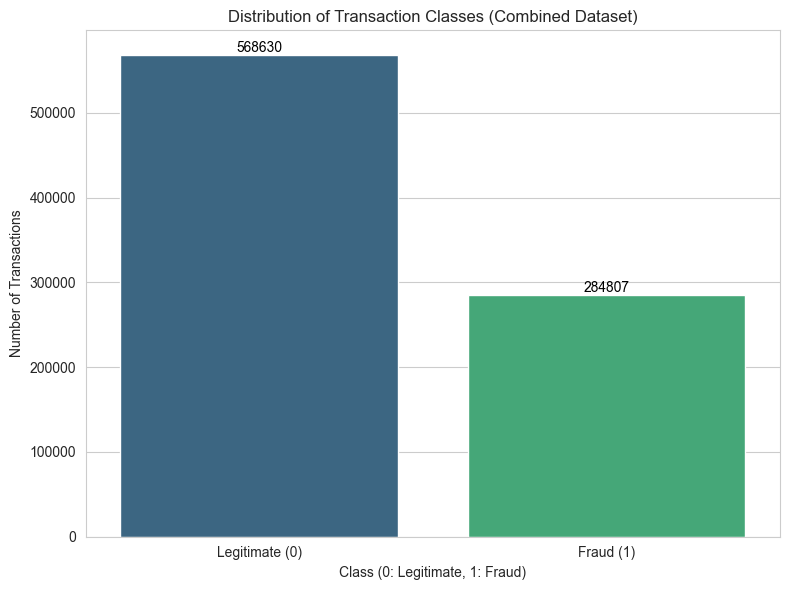

In [10]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_combined, palette='viridis')
plt.title('Distribution of Transaction Classes (Combined Dataset)')
plt.xlabel('Class (0: Legitimate, 1: Fraud)')
plt.ylabel('Number of Transactions')
plt.xticks(ticks=[0, 1], labels=['Legitimate (0)', 'Fraud (1)'])
plt.text(0, y_combined.value_counts()[0], f'{y_combined.value_counts()[0]}', ha='center', va='bottom', color='black', fontsize=10)
plt.text(1, y_combined.value_counts()[1], f'{y_combined.value_counts()[1]}', ha='center', va='bottom', color='black', fontsize=10)
plt.tight_layout()
plt.show()

In [11]:
# Missing values check
missing_values = X_combined_raw.isnull().sum().sum()
print("\nMissing Values in Combined Dataset:")
print(missing_values)
if missing_values == 0:
    print("No missing values detected. Data is clean for further processing.")
else:
    print(f"Error: {missing_values} missing values detected in combined dataset.")
    raise ValueError("Missing values in combined dataset")


Missing Values in Combined Dataset:
0
No missing values detected. Data is clean for further processing.


In [12]:
# Discussion Point: Class Imbalance in Combined Dataset
fraud_ratio = y_combined.value_counts(normalize=True)[1] * 100
print(f"\nDiscussion: The combined dataset has a fraud ratio of {fraud_ratio:.2f}%. "
      f"This is significantly less imbalanced than the 2013 dataset (0.17% fraud) but not perfectly balanced like the 2023 dataset (50% fraud). "
      f"This new imbalance level (~{fraud_ratio:.2f}%) suggests that imbalance handling techniques (e.g., class weighting, SMOTE) will still be necessary, "
      f"but their impact may be less pronounced than in Phase 1. The model will need to learn patterns from both the subtle, rare fraud cases of 2013 and "
      f"the highly separable fraud cases of 2023, which could affect its generalization ability.")

print("\n" + "="*80 + "\n")
print("--- Phase 4, Step 1: Data Consolidation & Initial Analysis Complete ---")


Discussion: The combined dataset has a fraud ratio of 33.37%. This is significantly less imbalanced than the 2013 dataset (0.17% fraud) but not perfectly balanced like the 2023 dataset (50% fraud). This new imbalance level (~33.37%) suggests that imbalance handling techniques (e.g., class weighting, SMOTE) will still be necessary, but their impact may be less pronounced than in Phase 1. The model will need to learn patterns from both the subtle, rare fraud cases of 2013 and the highly separable fraud cases of 2023, which could affect its generalization ability.


--- Phase 4, Step 1: Data Consolidation & Initial Analysis Complete ---


In [13]:
# --- Reload Combined Data ---
# This block ensures X_combined_raw and y_combined are available if the notebook was reset.
print("--- Reloading Combined Data ---")
try:
    # Attempt to load raw data and combine if not in memory
    if 'X_combined_raw' not in locals() or 'y_combined' not in locals():
        data_dir = Path('../data')
        df_2013_raw = pd.read_csv(data_dir / 'creditcard.csv')
        df_2023_raw = pd.read_csv(data_dir / 'creditcard_2023.csv')
        common_features = [f'V{i}' for i in range(1, 29)] + ['Amount']
        target_column = 'Class'
        X_2013_common = df_2013_raw[common_features].copy()
        y_2013 = df_2013_raw[target_column].copy()
        X_2023_common = df_2023_raw[common_features].copy()
        y_2023 = df_2023_raw[target_column].copy()
        X_combined_raw = pd.concat([X_2013_common, X_2023_common], axis=0, ignore_index=True)
        y_combined = pd.concat([y_2013, y_2023], axis=0, ignore_index=True)
        print("Combined raw data reloaded/recreated successfully.")
    else:
        print("Combined raw data already in memory.")
    print(f"Current X_combined_raw shape: {X_combined_raw.shape}")
    print(f"Current y_combined shape: {y_combined.shape}")
except Exception as e:
    print(f"Error during combined data reload: {e}")
    exit()

print("\n" + "="*80 + "\n")

--- Reloading Combined Data ---
Combined raw data already in memory.
Current X_combined_raw shape: (853437, 29)
Current y_combined shape: (853437,)




## Step 2: Preprocessing Combined Data

In [14]:
# --- Step 2: Preprocessing Combined Data ---
print("--- Phase 4, Step 2: Preprocessing Combined Data ---")

--- Phase 4, Step 2: Preprocessing Combined Data ---


Train-Test Split (on Combined Data)

In [15]:
# 2.1 Train-Test Split (on Combined Data)
print("\n--- 2.1 Train-Test Split (Combined Data) ---")
# Perform a fresh train-test split with stratification
X_train_combined_raw, X_test_combined_raw, y_train_combined, y_test_combined = train_test_split(
    X_combined_raw, y_combined, test_size=0.20, random_state=RANDOM_STATE, stratify=y_combined
)

print(f"Combined training raw shape: {X_train_combined_raw.shape}")
print(f"Combined testing raw shape: {X_test_combined_raw.shape}")

print("\nClass distribution in combined training set:")
print(y_train_combined.value_counts(normalize=True) * 100)
print("\nClass distribution in combined testing set:")
print(y_test_combined.value_counts(normalize=True) * 100)
print("Insight: Class distribution for the combined dataset successfully preserved in train/test splits.")

print("\n" + "="*80 + "\n")


--- 2.1 Train-Test Split (Combined Data) ---
Combined training raw shape: (682749, 29)
Combined testing raw shape: (170688, 29)

Class distribution in combined training set:
Class
0    66.628292
1    33.371708
Name: proportion, dtype: float64

Class distribution in combined testing set:
Class
0    66.628
1    33.372
Name: proportion, dtype: float64
Insight: Class distribution for the combined dataset successfully preserved in train/test splits.




Feature Scaling (on Combined Data)

In [16]:
# 2.2 Feature Scaling (on Combined Data)
print("--- 2.2 Feature Scaling (Combined Data) ---")
# Initialize a new StandardScaler for the combined dataset
scaler_combined = StandardScaler()
# Fit the scaler ONLY on the training data of the combined set
X_train_combined_scaled = scaler_combined.fit_transform(X_train_combined_raw)
X_train_combined_scaled = pd.DataFrame(X_train_combined_scaled, columns=X_combined_raw.columns)  # Convert back to DataFrame
# Transform the test data using the fitted scaler
X_test_combined_scaled = scaler_combined.transform(X_test_combined_raw)
X_test_combined_scaled = pd.DataFrame(X_test_combined_scaled, columns=X_combined_raw.columns)  # Convert back to DataFrame

print("Features scaled using StandardScaler fitted on combined training data.")
print(f"Shape of scaled combined train: {X_train_combined_scaled.shape}")
print(f"Shape of scaled combined test: {X_test_combined_scaled.shape}")

--- 2.2 Feature Scaling (Combined Data) ---
Features scaled using StandardScaler fitted on combined training data.
Shape of scaled combined train: (682749, 29)
Shape of scaled combined test: (170688, 29)


In [17]:
# Verify scaling (mean should be close to 0, std close to 1)
print("\nSummary statistics of a few scaled combined train features:")
print(X_train_combined_scaled.describe().iloc[:, :3])  # Display first 3 columns
print("\nSummary statistics of a few scaled combined test features:")
print(X_test_combined_scaled.describe().iloc[:, :3])  # Display first 3 columns
print("\nInsight: All features in the combined dataset have been scaled consistently based on the combined training data's distribution.")

print("\n" + "="*80 + "\n")


Summary statistics of a few scaled combined train features:
                 V1            V2            V3
count  6.827490e+05  6.827490e+05  6.827490e+05
mean  -1.401834e-17 -9.855510e-18  1.459073e-17
std    1.000001e+00  1.000001e+00  1.000001e+00
min   -3.365878e+01 -5.052112e+01 -4.042410e+01
25%   -4.901627e-01 -4.038459e-01 -5.764221e-01
50%   -5.847193e-02 -7.432885e-02  3.074607e-02
75%    7.225728e-01  3.819198e-01  6.288547e-01
max    1.761202e+00  1.759267e+01  1.181613e+01

Summary statistics of a few scaled combined test features:
                  V1             V2             V3
count  170688.000000  170688.000000  170688.000000
mean       -0.000647       0.001262      -0.000220
std         1.011210       1.006664       1.007614
min       -40.520857     -57.995101     -26.611914
25%        -0.491193      -0.403133      -0.573597
50%        -0.059545      -0.073768       0.029734
75%         0.723188       0.380734       0.628941
max         1.763387      13.892717    

Data Integrity & Saving

In [18]:
# 2.3 Data Integrity & Saving
print("--- 2.3 Data Integrity & Saving ---")
# Check for NaN values post-scaling
nan_check_train = X_train_combined_scaled.isnull().sum().sum()
nan_check_test = X_test_combined_scaled.isnull().sum().sum()
print(f"NaN check after scaling (train set): {nan_check_train}")
print(f"NaN check after scaling (test set): {nan_check_test}")

if nan_check_train == 0 and nan_check_test == 0:
    print("No missing values detected after scaling. Data integrity maintained.")
else:
    print("Warning: Missing values detected after scaling!")

--- 2.3 Data Integrity & Saving ---
NaN check after scaling (train set): 0
NaN check after scaling (test set): 0
No missing values detected after scaling. Data integrity maintained.


In [19]:
# Define output directory and file path
output_dir = data_dir  # Use the already defined data_dir Path object
output_filename = output_dir / 'preprocessed_data_combined.pkl'

In [20]:
# Save preprocessed data (X_train, X_test, y_train, y_test for combined)
joblib.dump(
    (X_train_combined_scaled, X_test_combined_scaled, y_train_combined, y_test_combined),
    output_filename
)
joblib.dump(scaler_combined, output_dir / 'scaler_combined.pkl')  # Save the scaler as well
print(f"\nPreprocessed combined data splits and scaler saved to '{output_filename}' and '{output_dir / 'scaler_combined.pkl'}'")


Preprocessed combined data splits and scaler saved to '..\data\preprocessed_data_combined.pkl' and '..\data\scaler_combined.pkl'


In [21]:
# Verify saved file by loading
loaded_data_combined = joblib.load(output_filename)
print("Loaded data shapes (verification):", [d.shape for d in loaded_data_combined[:4]])
print("\nInsight: Data integrity verified, and preprocessed combined data splits are ready for modeling.")

print("\n" + "="*80 + "\n")
print("--- Phase 4, Step 2: Preprocessing Combined Data Complete ---")

Loaded data shapes (verification): [(682749, 29), (170688, 29), (682749,), (170688,)]

Insight: Data integrity verified, and preprocessed combined data splits are ready for modeling.


--- Phase 4, Step 2: Preprocessing Combined Data Complete ---


In [22]:
# --- Reload Preprocessed Combined Data (if necessary) ---
print("--- Reloading Preprocessed Combined Data (if necessary) ---")
try:
    # Define path to the preprocessed combined data
    data_dir = Path('../data')
    preprocessed_combined_path = data_dir / 'preprocessed_data_combined.pkl'

    # Load data
    loaded_combined_data = joblib.load(preprocessed_combined_path)
    X_train_combined_scaled = loaded_combined_data[0]
    X_test_combined_scaled = loaded_combined_data[1]
    y_train_combined = loaded_combined_data[2]
    y_test_combined = loaded_combined_data[3]

    print(f"Preprocessed combined data loaded successfully from '{preprocessed_combined_path}'.")
    print(f"X_train_combined_scaled shape: {X_train_combined_scaled.shape}, y_train_combined shape: {y_train_combined.shape}")
    print(f"X_test_combined_scaled shape: {X_test_combined_scaled.shape}, y_test_combined shape: {y_test_combined.shape}")

except FileNotFoundError:
    print(f"Error: '{preprocessed_combined_path}' not found. Ensure Phase 4, Step 2 was completed and saved the file.")
    exit()
except Exception as e:
    print(f"Error reloading combined data: {e}")
    exit()

print("\n" + "="*80 + "\n")

--- Reloading Preprocessed Combined Data (if necessary) ---
Preprocessed combined data loaded successfully from '..\data\preprocessed_data_combined.pkl'.
X_train_combined_scaled shape: (682749, 29), y_train_combined shape: (682749,)
X_test_combined_scaled shape: (170688, 29), y_test_combined shape: (170688,)




In [23]:
# Initialize a list to store results for Phase 4
# Ensure this list is initialized once or loaded if continuing from previous execution
if 'combined_training_results' not in locals():
    combined_training_results = []
    print("Initialized new 'combined_training_results' list.")
else:
    print("'combined_training_results' list already exists. Appending to it.")

'combined_training_results' list already exists. Appending to it.


## Model Selection & Training

In [24]:
# --- Step 3: Model Selection & Training ---
print("--- Phase 4, Step 3: Model Selection & Training (Combined Data) ---")

--- Phase 4, Step 3: Model Selection & Training (Combined Data) ---


Handling Imbalance Strategy for Combined Data

In [25]:
# --- 3.1 Handling Imbalance Strategy for Combined Data ---
print("\n--- 3.1 Handling Imbalance Strategy for Combined Data ---")
# Calculate the scale_pos_weight for the combined dataset's imbalance
# This will be used for XGBoost. For LR and RF, 'class_weight="balanced"' will be used.
scale_pos_weight_combined = (y_train_combined == 0).sum() / (y_train_combined == 1).sum()
print(f"Combined training data fraud ratio: {y_train_combined.value_counts(normalize=True)[1] * 100:.2f}%")
print(f"Calculated scale_pos_weight for combined data: {scale_pos_weight_combined:.2f}")

print("\nInsight: The combined dataset is moderately imbalanced (~33.37% fraud). Class weighting will be used to help models prioritize the minority class effectively.")


--- 3.1 Handling Imbalance Strategy for Combined Data ---
Combined training data fraud ratio: 33.37%
Calculated scale_pos_weight for combined data: 2.00

Insight: The combined dataset is moderately imbalanced (~33.37% fraud). Class weighting will be used to help models prioritize the minority class effectively.


Model Training and Evaluation

In [26]:
# --- 3.2 Model Training and Evaluation ---
print("\n--- 3.2 Model Training and Evaluation ---")


--- 3.2 Model Training and Evaluation ---


Logistic Regression with Class Weighting


--- Training Logistic Regression (Combined Data) with Class Weighting ---
--- Evaluating Logistic Regression (Combined) (Class Weighting) ---

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94    113726
           1       0.89      0.89      0.89     56962

    accuracy                           0.93    170688
   macro avg       0.92      0.92      0.92    170688
weighted avg       0.93      0.93      0.93    170688


Confusion Matrix:
[[107447   6279]
 [  6378  50584]]


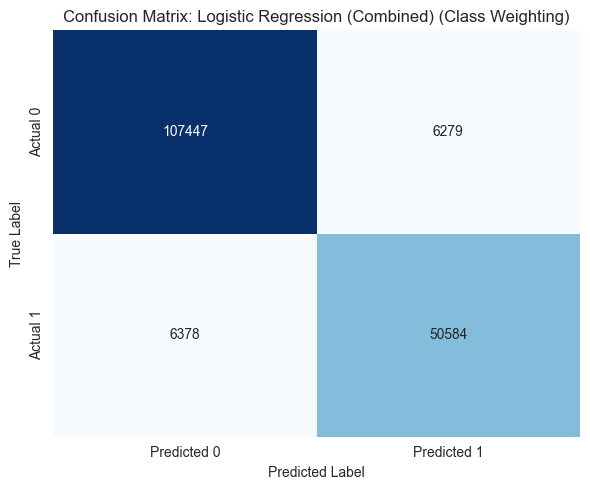


ROC AUC Score: 0.9575
Precision-Recall AUC (AUPRC): 0.9422


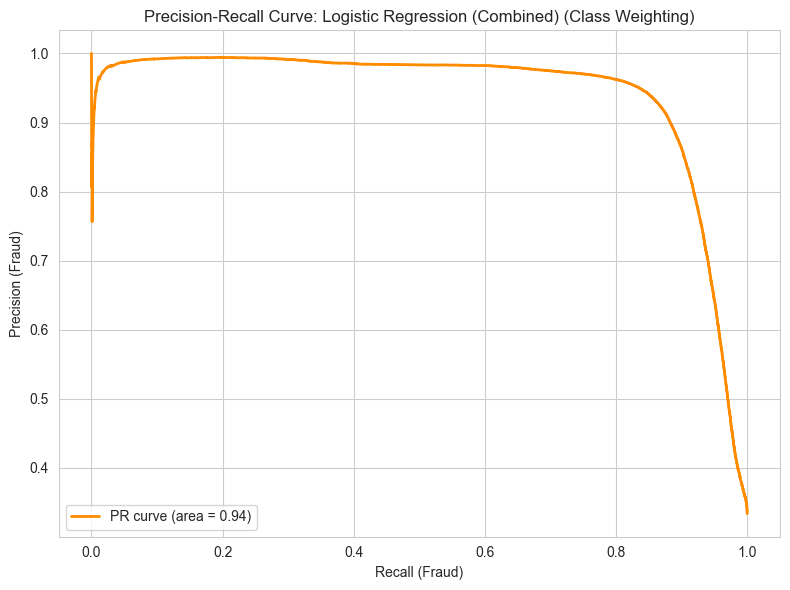

In [27]:
# Logistic Regression with Class Weighting
print("\n--- Training Logistic Regression (Combined Data) with Class Weighting ---")
lr_combined = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE)
lr_combined.fit(X_train_combined_scaled, y_train_combined)
evaluate_model(lr_combined, X_test_combined_scaled, y_test_combined,
               'Logistic Regression (Combined)', 'Class Weighting', combined_training_results)

Random Forest Classifier with Class Weighting


--- Training Random Forest (Combined Data) with Class Weighting ---
--- Evaluating Random Forest (Combined) (Class Weighting) ---

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    113726
           1       1.00      1.00      1.00     56962

    accuracy                           1.00    170688
   macro avg       1.00      1.00      1.00    170688
weighted avg       1.00      1.00      1.00    170688


Confusion Matrix:
[[113707     19]
 [    34  56928]]


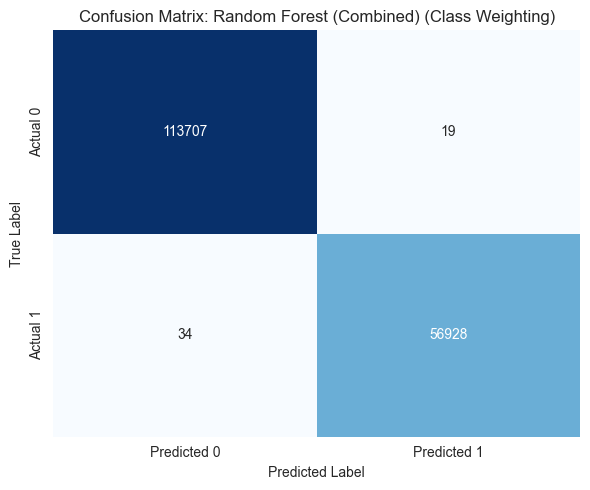


ROC AUC Score: 0.9999
Precision-Recall AUC (AUPRC): 0.9999


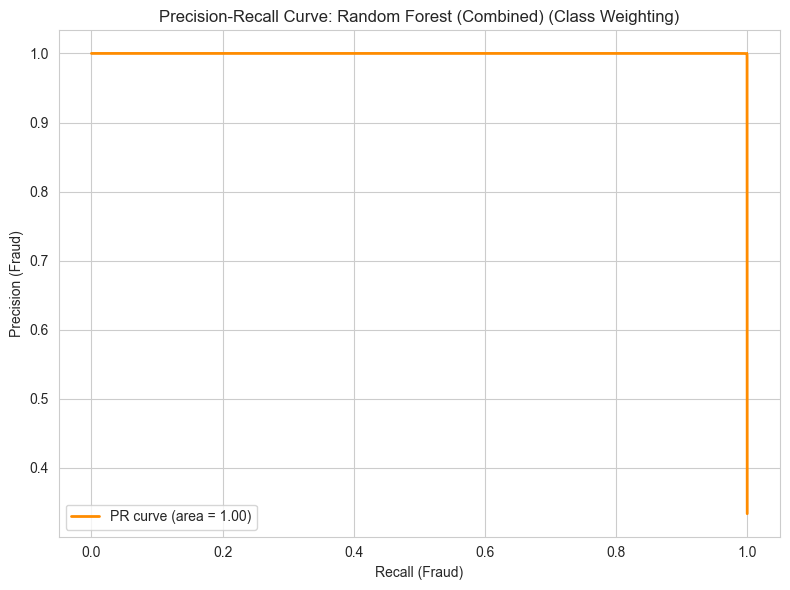

In [28]:
# Random Forest Classifier with Class Weighting
print("\n--- Training Random Forest (Combined Data) with Class Weighting ---")
rf_combined = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE, n_estimators=100, n_jobs=-1)
rf_combined.fit(X_train_combined_scaled, y_train_combined)
evaluate_model(rf_combined, X_test_combined_scaled, y_test_combined,
               'Random Forest (Combined)', 'Class Weighting', combined_training_results)

XGBoost Classifier with scale_pos_weight


--- Training XGBoost (Combined Data) with scale_pos_weight ---


C:\Users\PAVITHRAN\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [13:32:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Evaluating XGBoost (Combined) (Class Weighting) ---

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    113726
           1       1.00      1.00      1.00     56962

    accuracy                           1.00    170688
   macro avg       1.00      1.00      1.00    170688
weighted avg       1.00      1.00      1.00    170688


Confusion Matrix:
[[113670     56]
 [    19  56943]]


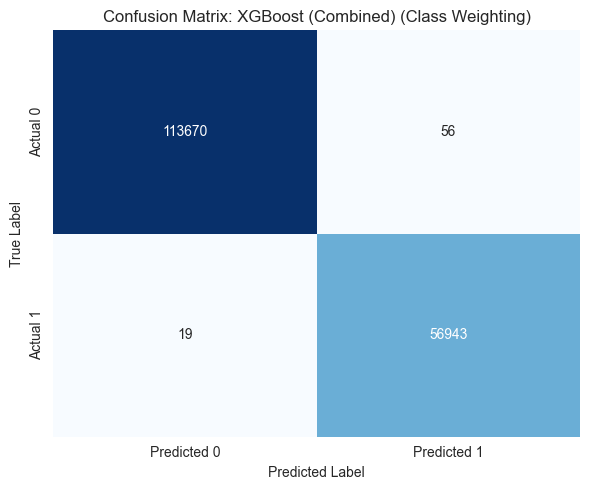


ROC AUC Score: 1.0000
Precision-Recall AUC (AUPRC): 1.0000


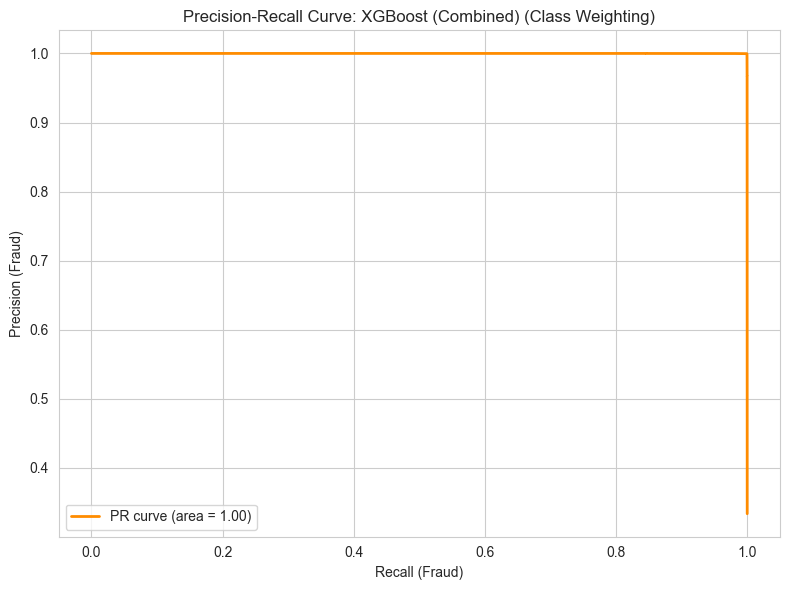

In [29]:
# XGBoost Classifier with scale_pos_weight
print("\n--- Training XGBoost (Combined Data) with scale_pos_weight ---")
xgb_combined = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                             scale_pos_weight=scale_pos_weight_combined,
                             random_state=RANDOM_STATE, n_estimators=100, n_jobs=-1)
xgb_combined.fit(X_train_combined_scaled, y_train_combined)
evaluate_model(xgb_combined, X_test_combined_scaled, y_test_combined,
               'XGBoost (Combined)', 'Class Weighting', combined_training_results)

## Step 4: Final Model Selection & Analysis

In [30]:
# --- Phase 4, Step 4: Final Model Selection & Analysis ---
print("--- Phase 4, Step 4: Final Model Selection & Analysis ---")

--- Phase 4, Step 4: Final Model Selection & Analysis ---


Initial Performance Comparison Summary for Combined Data

In [31]:
# 4.1 Initial Performance Comparison Summary for Combined Data
print("\n--- 4.1 Initial Performance Comparison Summary for Combined Dataset ---")
results_df_combined = pd.DataFrame(combined_training_results)

# Sort by AUPRC (descending)
results_df_combined_sorted = results_df_combined.sort_values(by='AUPRC', ascending=False)

print("\nSummary of Model Performance for Combined Dataset (Sorted by AUPRC):")
print(results_df_combined_sorted[['Model', 'Strategy', 'Accuracy', 'Precision (Fraud)', 'Recall (Fraud)', 'F1-Score (Fraud)', 'AUPRC', 'ROC AUC', 'True Positives (TP)', 'False Positives (FP)', 'False Negatives (FN)']
].round(4))

print("\nInsight: Review the table above to identify the best model and strategy for the combined dataset. Compare these results with previous phases.")


--- 4.1 Initial Performance Comparison Summary for Combined Dataset ---

Summary of Model Performance for Combined Dataset (Sorted by AUPRC):
                            Model         Strategy  Accuracy  \
2              XGBoost (Combined)  Class Weighting    0.9996   
1        Random Forest (Combined)  Class Weighting    0.9997   
0  Logistic Regression (Combined)  Class Weighting    0.9258   

   Precision (Fraud)  Recall (Fraud)  F1-Score (Fraud)   AUPRC  ROC AUC  \
2             0.9990          0.9997            0.9993  1.0000   1.0000   
1             0.9997          0.9994            0.9995  0.9999   0.9999   
0             0.8896          0.8880            0.8888  0.9422   0.9575   

   True Positives (TP)  False Positives (FP)  False Negatives (FN)  
2                56943                    56                    19  
1                56928                    19                    34  
0                50584                  6279                  6378  

Insight: Review the ta

In [32]:
# Save results_df_combined to a file
output_results_file = data_dir / 'phase4_results_combined.pkl'
joblib.dump(results_df_combined, output_results_file)
print(f"Model performance results saved to {output_results_file}")

Model performance results saved to ..\data\phase4_results_combined.pkl


Save Best Model (based on AUPRC)

In [33]:
# 4.2 Save Best Model (based on AUPRC)
print("\n--- 4.2 Saving Best Model (from Combined Training) ---")
# Select the best model based on AUPRC
best_model_idx = results_df_combined['AUPRC'].idxmax()
best_model_info = results_df_combined.loc[best_model_idx]

# Map the best_model_info back to the actual model object
if best_model_info['Model'] == 'XGBoost (Combined)':
    best_model_combined = xgb_combined
elif best_model_info['Model'] == 'Random Forest (Combined)':
    best_model_combined = rf_combined
else:  # Logistic Regression
    best_model_combined = lr_combined

# Clean filename by removing extra parentheses and spaces
output_model_file = data_dir / f'best_model_combined_{best_model_info["Model"].replace(" ", "_").replace("_(", "_").replace(")", "").lower()}_{best_model_info["Strategy"].replace(" ", "_").lower()}.pkl'
joblib.dump(best_model_combined, output_model_file)
print(f"Best combined model ({best_model_info['Model']} with {best_model_info['Strategy']}) saved to {output_model_file}")


--- 4.2 Saving Best Model (from Combined Training) ---
Best combined model (XGBoost (Combined) with Class Weighting) saved to ..\data\best_model_combined_xgboost_combined_class_weighting.pkl


Visualize Feature Importance (for Tree-based Models)


--- 4.3 Visualize Feature Importance (for Tree-based Models) ---


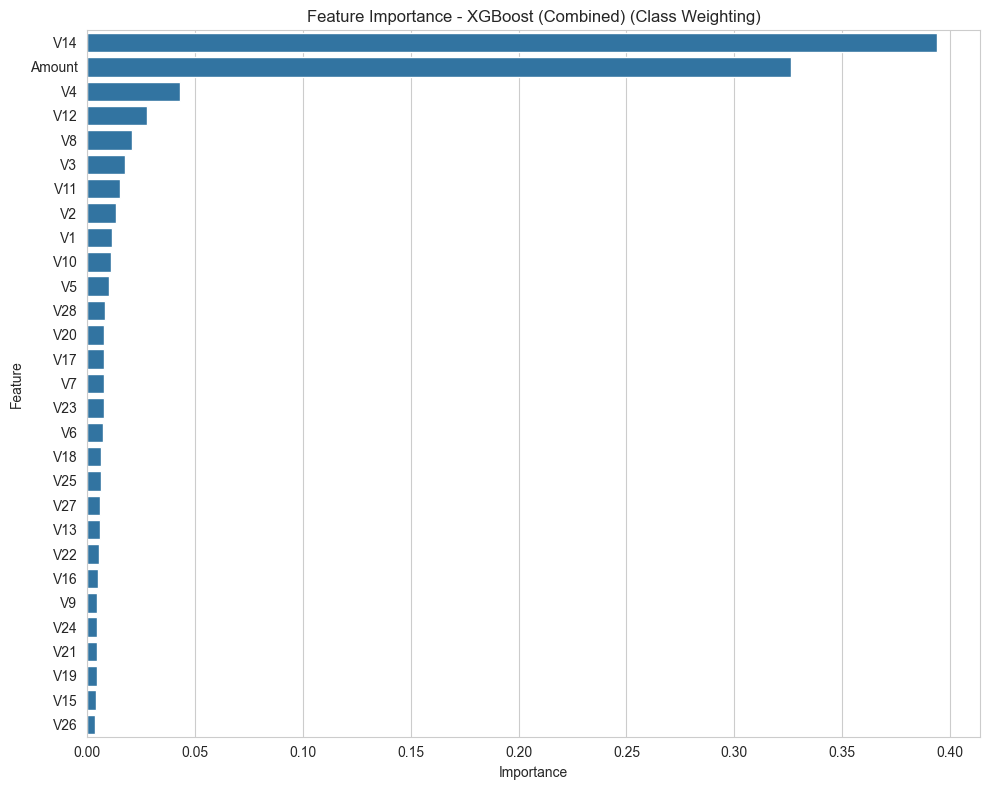


Insight: Feature importance visualization provides insights into which features are most influential in the combined model's predictions.


--- Phase 4, Step 3: Model Selection & Training Complete ---


In [34]:
# 4.3 Visualize Feature Importance (for Tree-based Models)
print("\n--- 4.3 Visualize Feature Importance (for Tree-based Models) ---")
if isinstance(best_model_combined, (RandomForestClassifier, XGBClassifier)):
    # Get feature names from the scaled training data (which is a DataFrame)
    feature_names_combined = X_train_combined_scaled.columns
    importances_combined = best_model_combined.feature_importances_

    feature_importance_df_combined = pd.DataFrame({'Feature': feature_names_combined, 'Importance': importances_combined})
    feature_importance_df_combined = feature_importance_df_combined.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df_combined)
    plt.title(f'Feature Importance - {best_model_info["Model"]} ({best_model_info["Strategy"]})')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    print("\nInsight: Feature importance visualization provides insights into which features are most influential in the combined model's predictions.")
else:
    print(f"Feature importance visualization not available for {best_model_info['Model']}.")

print("\n" + "="*80 + "\n")
print("--- Phase 4, Step 3: Model Selection & Training Complete ---")  # Renamed from Step 4 to reflect combined progress